In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import utils
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset = utils.load_dataset('pnsahoo/MATH500_with_Llama_3.1_70B_Instruct_v1_truncated_K_50')
dev_ds, val_ds, test_ds = utils.dev_test_split(dataset)

README.md: 0.00B [00:00, ?B/s]

data/data-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating data split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [61]:
# Publish test_ds to HuggingFace Hub
from datasets import DatasetDict
from huggingface_hub import login

# Login to HuggingFace (if not already logged in)
# Option 1: Use environment variable HF_TOKEN
# Option 2: Interactive login - uncomment below:
# login()

# Replace "your-username" and "dataset-name" with your desired repo
repo_id = "amyguan/math500-k50-test"

# Wrap in DatasetDict with "data" split (matches original format)
dataset_dict = DatasetDict({"data": test_ds})

# Push to hub
dataset_dict.push_to_hub(repo_id, private=False)  # Set private=True for private repo
print(f"✅ Published to: https://huggingface.co/datasets/{repo_id}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✅ Published to: https://huggingface.co/datasets/amyguan/math500-k50-test


In [80]:
repo_id = "amyguan/math500-k50-dev"

# Wrap in DatasetDict with "data" split (matches original format)
dataset_dict = DatasetDict({"data": dev_ds})

# Push to hub
dataset_dict.push_to_hub(repo_id, private=False)  # Set private=True for private repo
print(f"✅ Published to: https://huggingface.co/datasets/{repo_id}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✅ Published to: https://huggingface.co/datasets/amyguan/math500-k50-dev


In [75]:
### DO ON THE DEV SET FOR MODEL SELECTION ###
scores_matrix, verifier_names = utils.extract_scores_matrix(dev_ds)
similarities = utils.similarities_dict(scores_matrix)
utilities = utils.utilities_dict(scores_matrix, dev_ds, verifier_names)
param_counts = utils.costs_dict(verifier_names)

Number of verifiers: 35
Ground truth shape: (5000,)
Overall accuracy: 0.801
Built parameter count vector. Missing: 0 of 35


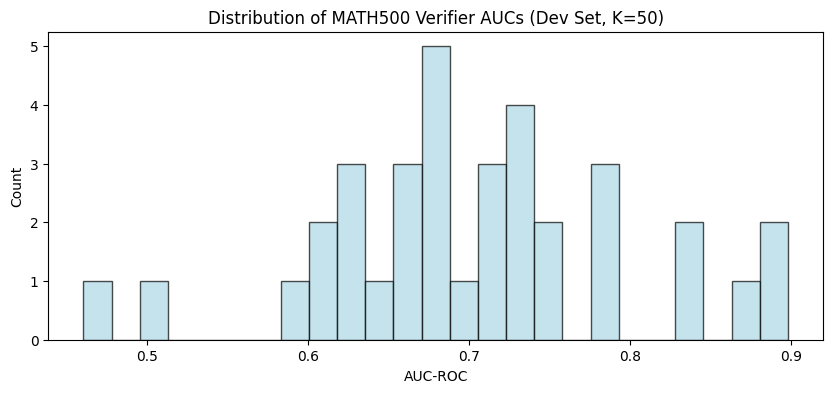

In [76]:
plt.figure(figsize=(10,4))
plt.hist([u for u in utilities if not np.isnan(u)], bins=25, color='lightblue', alpha=0.7, edgecolor='black')
plt.xlabel("AUC-ROC")
plt.ylabel("Count")
plt.title("Distribution of MATH500 Verifier AUCs (Dev Set, K=50)")
plt.show()

## RUN HERE

In [77]:
selected = utils.greedy_select(utilities,
    similarities['pearson'],
    verifier_names,
    k=10, # number of verifiers to select
    alpha=1.0, # utility weight
    beta=1.0, # similarity weight
    gamma=1.0, # parameter cost weight
    param_counts=param_counts)

In [78]:
selected

{'order': [17, 12, 30, 25, 18, 24, 28, 27, 1, 22],
 'step_scores': [0.824613713396491,
  0.699156764149717,
  0.4861301085703764,
  0.4709915477486611,
  0.38618555275018224,
  0.3847574483142858,
  0.2584194102963969,
  0.24792736402403004,
  0.2363279069592042,
  0.1432552304328269],
 'verifiers': ['QwenPRM_min_scores',
  'GPM_scores',
  'LDLRewardGemma_scores',
  'EurusPRMStage2_avg_scores',
  'QwenPRM_max_scores',
  'EurusPRMStage2_max_scores',
  'Qwen72B_scores',
  'InternLM2Reward7B_scores',
  'DeepSeekQwen32B_verdicts',
  'EurusPRMStage1_avg_scores'],
 'param_counts': [7.0, 8.0, 27.0, 7.0, 7.0, 7.0, 72.0, 7.0, 32.0, 7.0]}

In [79]:
print(selected['verifiers'])

['QwenPRM_min_scores', 'GPM_scores', 'LDLRewardGemma_scores', 'EurusPRMStage2_avg_scores', 'QwenPRM_max_scores', 'EurusPRMStage2_max_scores', 'Qwen72B_scores', 'InternLM2Reward7B_scores', 'DeepSeekQwen32B_verdicts', 'EurusPRMStage1_avg_scores']


In [ ]:
# verifier_names = selected['verifiers']
# verifier_names = list(set([f"{selected['verifiers'][i].split('_')[0]} ({int(selected['param_counts'][i])}B)" for i in range(len(selected['verifiers']))]))
# print(verifier_names)

['Skyworks (8B)', 'EurusPRMStage1 (7B)', 'ArmorRM (8B)', 'InternLM2Reward7B (7B)', 'EurusPRMStage2 (7B)', 'QwenPRM (7B)', 'GPM (8B)']


### Plotting Functions

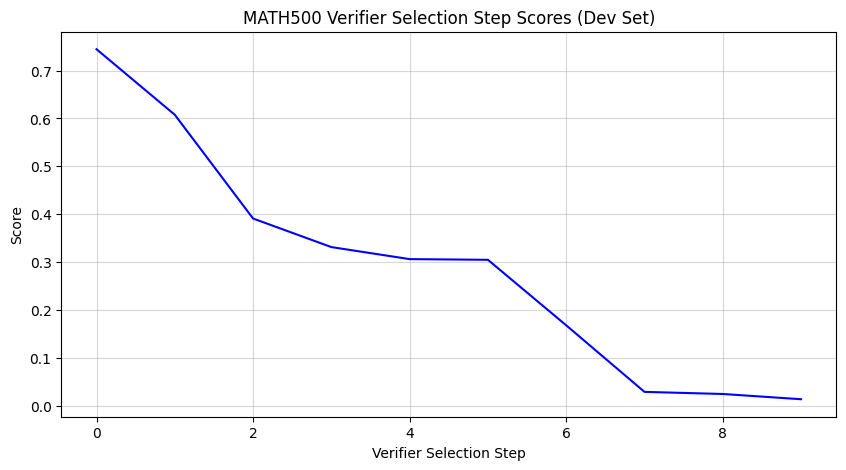

In [58]:
plt.figure(figsize=(10,5))
plt.plot(selected['step_scores'], color='blue')
plt.xlabel("Verifier Selection Step")
plt.ylabel("Score")
plt.title("MATH500 Verifier Selection Step Scores (Dev Set)")
plt.grid(True, alpha=0.5)
plt.show()

## Hyperparameter Search / Training Loop

In [49]:
print(selected['verifiers'])

['QwenPRM_min', 'GPM', 'EurusPRMStage2_avg', 'EurusPRMStage1_avg', 'QwenPRM_max', 'EurusPRMStage2_max', 'InternLM2Reward7B', 'Skyworks', 'ArmorRM', 'EurusPRMStage1_min']
